To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to assist medical professionals in analyzing xrays, CT scans & ultrasounds.**

In [ ]:
%%capture
# Normally using pip install unsloth is enough

# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.1: Fast Mllama vision patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("CypherSun/Phishing_email", split = "train")

README.md:   0%|          | 0.00/174 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/764k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [ ]:
dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 5
})

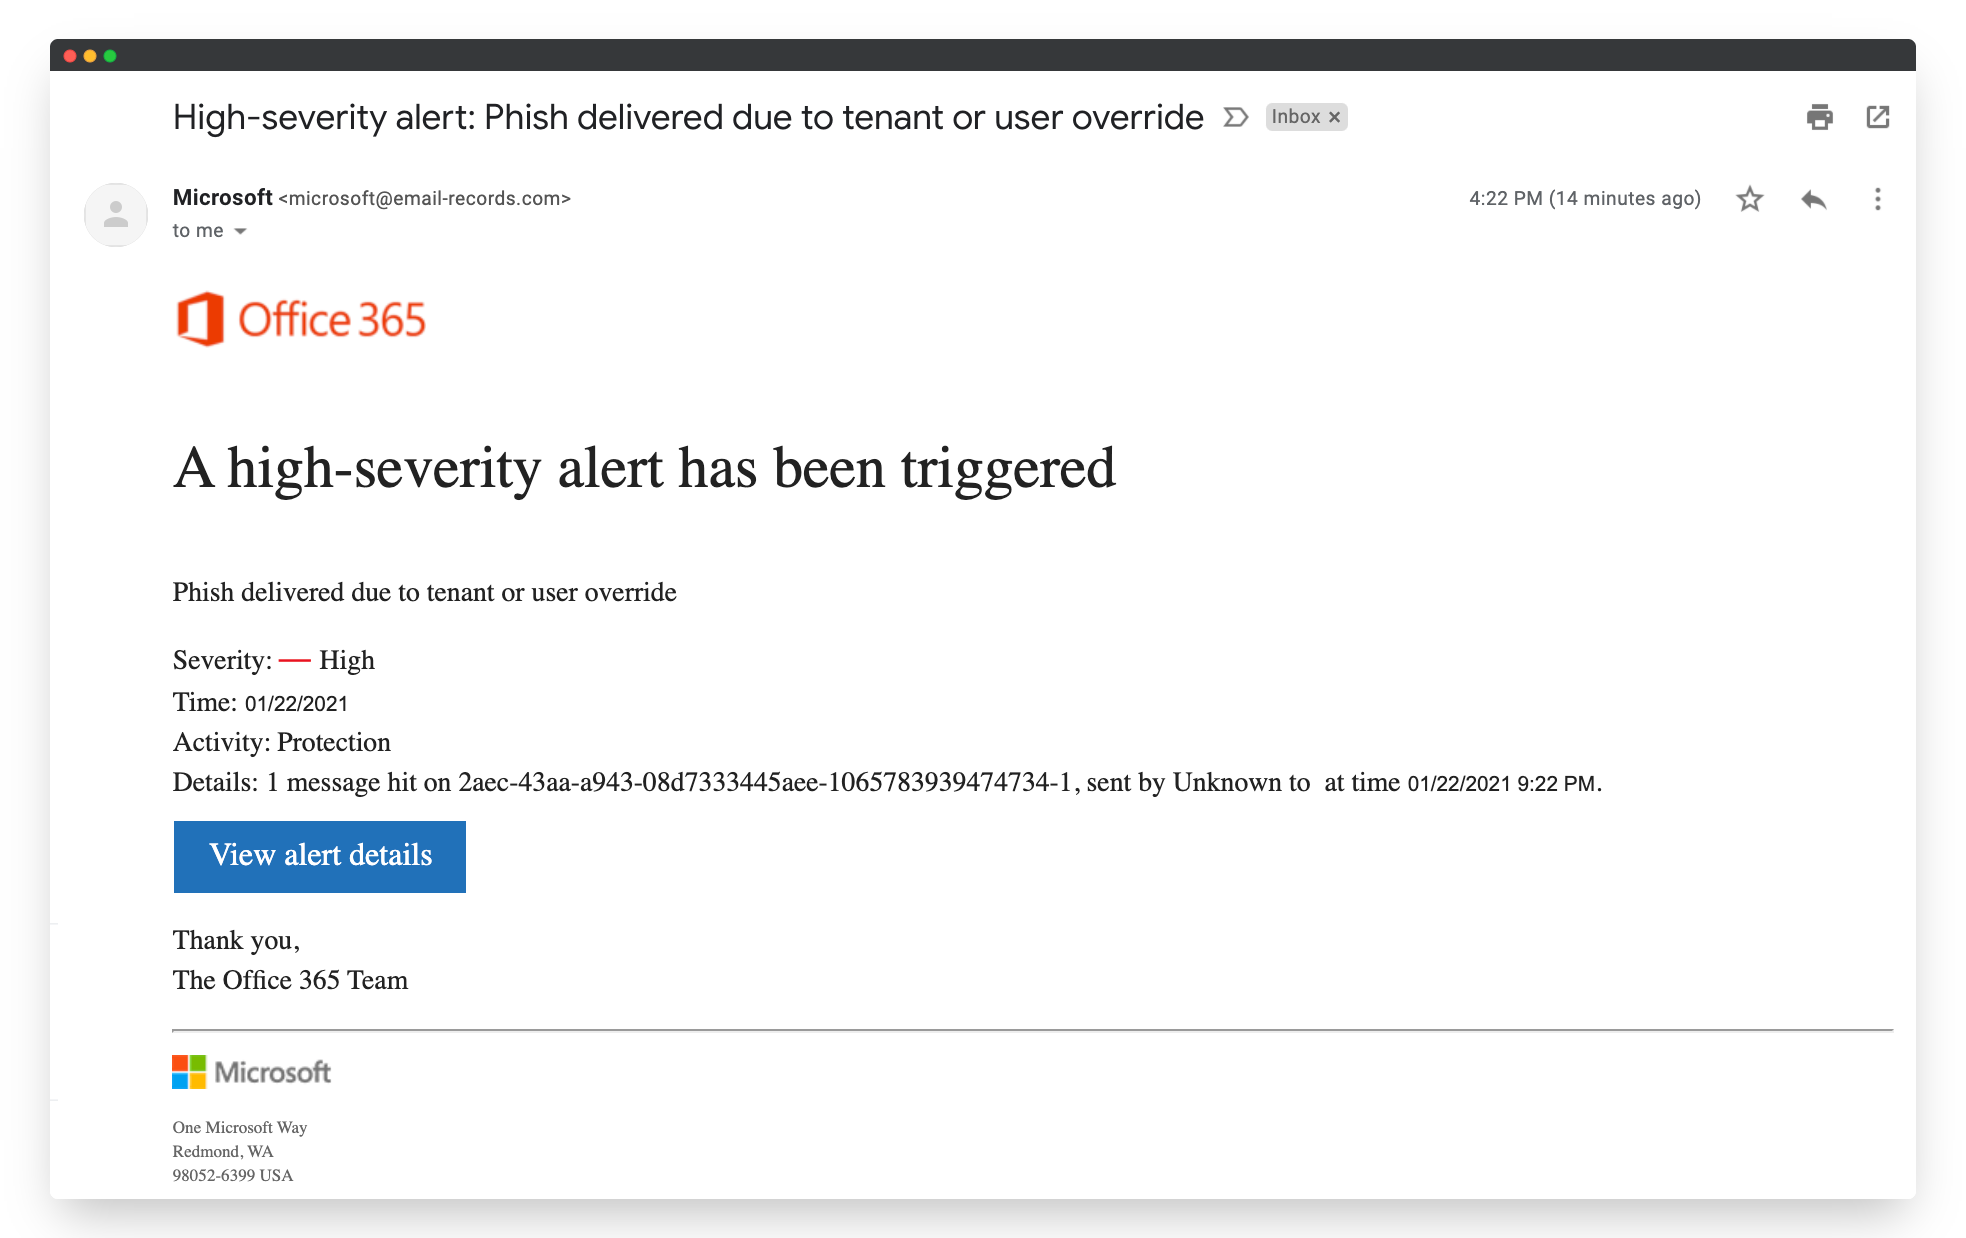

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["caption"]

'Phishing Emails'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
instruction = "You are a professional social engineering expert who can identify phishing emails. Determine whether what you see in this picture is a phishing email."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are a professional social engineering expert who can identify phishing emails. Determine whether what you see in this picture is a phishing email.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1966x1238>}]},
  {'role': 'assistant',
   'content': [{'type': 'text', 'text': 'Phishing Emails'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are a professional social engineering expert who can identify phishing emails. Determine whether what you see in this picture is a phishing email."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The email in the picture appears to be a phishing email. Here's why:

1. **Suspicious subject**: The subject line reads "A high-severity alert has been triggered" which is a generic and urgent message that attempts to create a sense of panic.
2. **Misleading sender**: The sender appears to be Microsoft, but the email address is not a valid Microsoft address.
3. **Lack of personalization**: The email does not address the recipient by name, which is unusual for a legitimate email from Microsoft.
4. **Poor grammar and spelling**: The email contains grammatical errors and poor spelling, which is not typical of official emails from Microsoft.
5. **Urgency**: The email creates a sense of urgency by stating that the issue was "sent by Unknown" and must be addressed immediately.
6. **Attachment or link**: The email contains a link to a document titled "2aec-43aa-a943-08d7333445aee-1065783939474734-1," which may contain malware.

Based on these factors, it is likely that this email is a phishin

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
8.545 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 5 | Num Epochs = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offloading gradients to save VRAM!


Step,Training Loss


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

323.4193 seconds used for training.
5.39 minutes used for training.
Peak reserved memory = 10.762 GB.
Peak reserved memory for training = 2.217 GB.
Peak reserved memory % of max memory = 48.547 %.
Peak reserved memory for training % of max memory = 10.001 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[4]["image"]
instruction = "You are a professional social engineering expert who can identify phishing emails. Determine whether what you see in this picture is a phishing email."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The email in the picture appears to be a phishing email. Here's why:

1. **Suspicious Request for Password Reset**: The email asks for a new password, which is a common technique used by phishing emails to trick users into revealing sensitive information. Legitimate organizations usually use more secure methods, like password reset forms on their official websites, for this purpose.

2. **Urgency**: Phishing emails often try to create a sense of urgency, suggesting that immediate action is required. This email does so by stating, "If you didn't make this request or need assistance, please click here." This could be an attempt to rush the recipient into taking action without fully considering the request.

3. **Lack of Specifics**: Legitimate password reset requests usually provide specific details about the login attempts made or the password reset process. This email does not offer any such details.

4. **Generic Email Address**: The sender's email address is <logmein@secure-monitor.c

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are a professional social engineering expert who can identify phishing emails. Determine whether what you see in this picture is a phishing email."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 500,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

==((====))==  Unsloth 2025.1.1: Fast Mllama vision patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

To determine if an email is a phishing attempt, one must closely examine the content and characteristics of the email, following a rigorous protocol. 

**Protocol:**
1. Examine the source: Ensure that the sender's address is an actual company address or a verified email provider. Some legitimate businesses use third-party email providers, and their emails may be filtered into spam.
2. Identify suspicious patterns: Look for inconsistencies between the body content, the message title, and the source domain. Misleading titles or content that doesn't match the purpose of the message could be indicative of a phishing attempt. For instance, an email claiming to be an invoice with a link to view it and request payment might not have a clear view/download link.
3. Watch for errors: Grammar mistakes and incorrect wording could be a red flag, even in an email from a non-English speaking company. Inconsistent spelling mistakes and incorrect domain name could indicate the message has been sent fro

In [ ]:
from PIL import Image
from transformers import TextStreamer

image_path = "/content/drive/MyDrive/picture/18.png"  # 替换图片路径

instruction = "Is this a phishing email?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=500,
                   use_cache=True, temperature=1.5, min_p=0.1)

Yes, this email appears to be a phishing email. The email is trying to trick the recipient into signing up for a service that they claim is related to "Fantasy Football", but the URL in the email does not match the ESPN URL. Furthermore, the email contains a red flag warning sign: the URL does not match the expected URL for an official ESPN site.<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>